# Merge metadata with ESCO Crosswalk
Felix Zaussinger | 18.05.2021

## Core Analysis Goal(s)
1. merge onet greenness scores and ASHE wage & employment data to onet-esco
crosswalk at isco 4-digit level

## Key Insight(s)
1. None

In [319]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [320]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

Read crosswalk

In [321]:
crosswalk = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "processed", "ESCO_ONET_xwalk_full.csv")
)

# decompose isco 4-digit level
crosswalk["isco_level_1"] = crosswalk["isco_level_4"].astype(str).str[:1].astype(int)
crosswalk["isco_level_2"] = crosswalk["isco_level_4"].astype(str).str[:2].astype(int)
crosswalk["isco_level_3"] = crosswalk["isco_level_4"].astype(str).str[:3].astype(int)

In [322]:
crosswalk.query("isco_level_4 == 8211")

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3
51,51,http://data.europa.eu/esco/occupation/036dc42f...,aircraft engine assembler,8211,51-2011.00,"aircraft structure, surfaces, rigging, and sys...",8,82,821
318,318,http://data.europa.eu/esco/occupation/1a6d1acf...,mechatronics assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
1417,1417,http://data.europa.eu/esco/occupation/769159bd...,motorcycle assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
1450,1450,http://data.europa.eu/esco/occupation/78625dd8...,motor vehicle parts assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
1581,1581,http://data.europa.eu/esco/occupation/839d738b...,rolling stock assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
1636,1636,http://data.europa.eu/esco/occupation/88a34087...,vessel engine assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
2051,2051,http://data.europa.eu/esco/occupation/ad7c76e8...,aircraft assembler,8211,51-2011.00,"aircraft structure, surfaces, rigging, and sys...",8,82,821
2251,2251,http://data.europa.eu/esco/occupation/be0e6189...,industrial machinery assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
2317,2317,http://data.europa.eu/esco/occupation/c3cae318...,motor vehicle engine assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821
2875,2875,http://data.europa.eu/esco/occupation/fa3fde92...,motor vehicle body assembler,8211,51-2031.00,engine and other machine assemblers,8,82,821


Read greenness data

In [323]:
greenness = pd.read_excel(
    io=os.path.join(data_raw, "onet", "Onet_GreenTask_AppA.xlsx"),
    sheet_name="Occupations"
)

greenness.columns

Index(['onet_code', 'title', 'occupation_type', 'n_new_green_tasks',
       'n_existing_green_tasks', 'n_non_green_tasks', 'greenness_vona_2018'],
      dtype='object')

Read ASHE employment and earnings data (at 4-digit level)

In [324]:
uk_employment = pd.read_csv(
    os.path.join(data_raw, "onet", "onet_esco_crosswalk", "processed",
                 "linked_data", "ESCO_top_occupations_UK_employment.csv")
)

uk_employment  # [["isco_level_4", "employment_share", "employment_count"]]

,id,concept_uri,preferred_label,isco_level_3,isco_level_4,is_top_level,employment_share,employment_count
0,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,812,8121,True,0.000020,645.0
1,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,315,3155,True,0.000087,2797.0
2,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,243,2431,True,0.000648,20834.0
3,5,http://data.europa.eu/esco/occupation/0044c991...,medical laboratory assistant,321,3212,True,0.000647,20808.0
4,7,http://data.europa.eu/esco/occupation/00674f21...,primary school teaching assistant,531,5312,True,0.004302,138321.0
...,...,...,...,...,...,...,...,...
1696,2935,http://data.europa.eu/esco/occupation/ff5210a5...,cosmetics production machine operator,813,8131,True,0.000053,1699.0
1697,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,212,2120,True,0.000286,9184.0
1698,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,961,9612,True,0.000417,13414.0
1699,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,242,2422,True,0.001128,36261.0


In [325]:
uk_earnings = pd.read_csv(
    os.path.join(data_raw, "onet", "onet_esco_crosswalk", "processed",
                 "linked_data", "ESCO_occupations_UK_earnings_and_hours_imputed.csv")
)

uk_earnings[["isco_level_4", "total_paid_hours", "annual_earnings"]]

,isco_level_4,total_paid_hours,annual_earnings
0,2166,36.670202,37555.308176
1,8121,39.904110,22031.963636
2,7543,38.709386,22430.367647
3,3155,42.036716,32754.000000
4,2431,36.354676,38839.816377
...,...,...,...
2937,2120,35.494487,36135.290249
2938,9612,39.443972,21357.054545
2939,5414,37.021429,24315.540984
2940,2422,35.240566,33292.986333


In [326]:
uk_earnings.query("isco_level_4 == 8211")

,id,concept_uri,preferred_label,isco_title,isco_level_4,annual_earnings,total_paid_hours
51,51,http://data.europa.eu/esco/occupation/036dc42f...,aircraft engine assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
318,318,http://data.europa.eu/esco/occupation/1a6d1acf...,mechatronics assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
1417,1417,http://data.europa.eu/esco/occupation/769159bd...,motorcycle assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
1450,1450,http://data.europa.eu/esco/occupation/78625dd8...,motor vehicle parts assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
1581,1581,http://data.europa.eu/esco/occupation/839d738b...,rolling stock assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
1636,1636,http://data.europa.eu/esco/occupation/88a34087...,vessel engine assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
2051,2051,http://data.europa.eu/esco/occupation/ad7c76e8...,aircraft assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
2251,2251,http://data.europa.eu/esco/occupation/be0e6189...,industrial machinery assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
2317,2317,http://data.europa.eu/esco/occupation/c3cae318...,motor vehicle engine assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179
2875,2875,http://data.europa.eu/esco/occupation/fa3fde92...,motor vehicle body assembler,Mechanical machinery assemblers,8211,29879.320665,41.487179


read onet job zone data

In [327]:
job_zones = pd.read_csv(
    os.path.join(data_raw, "onet", "onet_esco_crosswalk", "processed",
                 "linked_data", "ESCO_occupations_Job_Zones.csv")
)

job_zones

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,O*NET-SOC Code,job_zone,education_level,related_work_experience,on_the_job_training
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,27-1011.00,4.0,6.2477,8.0309,4.3843
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",51-4021.00,2.0,2.1163,2.4383,3.6486
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",51-9061.00,2.0,2.5397,4.8863,4.0288
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,17-3023.01,3.0,4.3848,5.4808,4.0782
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,13-1161.00,4.0,6.8261,6.3481,3.8265
...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,15-2041.00,5.0,8.3000,5.5000,4.6000
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,51-9199.01,2.0,3.1532,3.3559,2.8314
2939,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,33-9032.00,2.0,2.2215,3.2642,2.0230
2940,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,11-3011.00,3.0,3.9636,6.9711,3.4248


left-join greenness index

In [328]:
df_merged_1 = pd.merge(
    left=crosswalk,
    right=greenness[['onet_code', 'occupation_type', 'n_new_green_tasks',
       'n_existing_green_tasks', 'n_non_green_tasks', 'greenness_vona_2018']],
    on="onet_code",
    how="left",
    validate="many_to_one"
)

df_merged_1

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,NaN,NaN,NaN,NaN,NaN
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,NaN,NaN,NaN,NaN,NaN
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,NaN,NaN,NaN,NaN,NaN
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,NaN,NaN,NaN,NaN,NaN
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000
2939,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,NaN,NaN,NaN,NaN,NaN
2940,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,NaN,NaN,NaN,NaN,NaN


left-join earnings data

In [329]:
df_merged_2 = pd.merge(
    left=df_merged_1,
    right=uk_earnings[["concept_uri", "total_paid_hours", "annual_earnings"]],
    on="concept_uri",
    how="left"
)

fill_values = {
    "occupation_type": "Non Green",
    # "n_new_green_tasks": 0,
    # "n_existing_green_tasks": 0,
    # "n_non_green_tasks": 0,
    # "greenness_vona_2018": 0
}
# fill empty values of green economy programme cols
df_merged_2.fillna(value=fill_values, inplace=True)

left-join employment data

In [330]:
uk_employment[["concept_uri", "employment_share", "employment_count"]]

,concept_uri,employment_share,employment_count
0,http://data.europa.eu/esco/occupation/000e93a3...,0.000020,645.0
1,http://data.europa.eu/esco/occupation/0022f466...,0.000087,2797.0
2,http://data.europa.eu/esco/occupation/002da35b...,0.000648,20834.0
3,http://data.europa.eu/esco/occupation/0044c991...,0.000647,20808.0
4,http://data.europa.eu/esco/occupation/00674f21...,0.004302,138321.0
...,...,...,...
1696,http://data.europa.eu/esco/occupation/ff5210a5...,0.000053,1699.0
1697,http://data.europa.eu/esco/occupation/ff656b3a...,0.000286,9184.0
1698,http://data.europa.eu/esco/occupation/ff8d4065...,0.000417,13414.0
1699,http://data.europa.eu/esco/occupation/ffade2f4...,0.001128,36261.0


In [331]:
df_merged_3 = pd.merge(
    left=df_merged_2,
    right=uk_employment[["concept_uri", "employment_share", "employment_count"]],
    on="concept_uri",
    how="left"
)

df_merged_3

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,total_paid_hours,annual_earnings,employment_share,employment_count
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,36.670202,37555.308176,NaN,NaN
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,39.904110,22031.963636,0.000020,645.0
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,38.709386,22430.367647,NaN,NaN
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,42.036716,32754.000000,0.000087,2797.0
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,36.354676,38839.816377,0.000648,20834.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,35.494487,36135.290249,0.000286,9184.0
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,39.443972,21357.054545,0.000417,13414.0
2939,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,37.021429,24315.540984,NaN,NaN
2940,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,35.240566,33292.986333,0.001128,36261.0


left-join job zone data

In [332]:
job_zones

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,O*NET-SOC Code,job_zone,education_level,related_work_experience,on_the_job_training
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,27-1011.00,4.0,6.2477,8.0309,4.3843
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",51-4021.00,2.0,2.1163,2.4383,3.6486
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",51-9061.00,2.0,2.5397,4.8863,4.0288
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,17-3023.01,3.0,4.3848,5.4808,4.0782
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,13-1161.00,4.0,6.8261,6.3481,3.8265
...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,15-2041.00,5.0,8.3000,5.5000,4.6000
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,51-9199.01,2.0,3.1532,3.3559,2.8314
2939,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,33-9032.00,2.0,2.2215,3.2642,2.0230
2940,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,11-3011.00,3.0,3.9636,6.9711,3.4248


In [333]:
df_merged_4 = pd.merge(
    left=df_merged_3,
    right=job_zones[["concept_uri", "job_zone", "education_level", "related_work_experience", "on_the_job_training"]],
    on="concept_uri",
    how="left"
)

df_merged_4

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training
0,0,http://data.europa.eu/esco/occupation/00030d09...,technical director,2166,27-1011.00,art directors,2,21,216,Non Green,NaN,NaN,NaN,NaN,36.670202,37555.308176,NaN,NaN,4.0,6.2477,8.0309,4.3843
1,1,http://data.europa.eu/esco/occupation/000e93a3...,metal drawing machine operator,8121,51-4021.00,"extruding and drawing machine setters, operato...",8,81,812,Non Green,NaN,NaN,NaN,NaN,39.904110,22031.963636,0.000020,645.0,2.0,2.1163,2.4383,3.6486
2,2,http://data.europa.eu/esco/occupation/0019b951...,precision device inspector,7543,51-9061.00,"inspectors, testers, sorters, samplers, and we...",7,75,754,Green Enhanced Skills,2.0,0.0,30.0,0.066667,38.709386,22430.367647,NaN,NaN,2.0,2.5397,4.8863,4.0288
3,3,http://data.europa.eu/esco/occupation/0022f466...,air traffic safety technician,3155,17-3023.01,electronics engineering technicians,3,31,315,Non Green,NaN,NaN,NaN,NaN,42.036716,32754.000000,0.000087,2797.0,3.0,4.3848,5.4808,4.0782
4,4,http://data.europa.eu/esco/occupation/002da35b...,hospitality revenue manager,2431,13-1161.00,market research analysts and marketing special...,2,24,243,Non Green,NaN,NaN,NaN,NaN,36.354676,38839.816377,0.000648,20834.0,4.0,6.8261,6.3481,3.8265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,2937,http://data.europa.eu/esco/occupation/ff656b3a...,demographer,2120,15-2041.00,statisticians,2,21,212,Non Green,NaN,NaN,NaN,NaN,35.494487,36135.290249,0.000286,9184.0,5.0,8.3000,5.5000,4.6000
2938,2938,http://data.europa.eu/esco/occupation/ff8d4065...,sorter labourer,9612,51-9199.01,recycling and reclamation workers,9,96,961,New Green N&E,18.0,0.0,0.0,1.000000,39.443972,21357.054545,0.000417,13414.0,2.0,3.1532,3.3559,2.8314
2939,2939,http://data.europa.eu/esco/occupation/ffa4dd5d...,armoured car guard,5414,33-9032.00,security guards,5,54,541,Non Green,NaN,NaN,NaN,NaN,37.021429,24315.540984,NaN,NaN,2.0,2.2215,3.2642,2.0230
2940,2940,http://data.europa.eu/esco/occupation/ffade2f4...,civil service administrative officer,2422,11-3011.00,administrative services managers,2,24,242,Non Green,NaN,NaN,NaN,NaN,35.240566,33292.986333,0.001128,36261.0,3.0,3.9636,6.9711,3.4248


Read ILO green transition scenario data

In [334]:
fpath_ilo = os.path.join(data_raw, "ilo_scenarios", "ilo_empl_scenarios_2030.xlsx")

ilo_scenarios = ["energy_sustainability", "circular_economy"]
df_ilo = pd.read_excel(
    io=fpath_ilo,
    sheet_name=ilo_scenarios
)

# convert to millions and calculate net employment change
scale_factor = 1000
numeric_cols = ['new_jobs_absorbing', 'new_jobs_net', 'jobs_lost_net', 'jobs_lost_reallocated', 'net_change']

for ilo_scenario in ilo_scenarios:
    df_ilo[ilo_scenario][numeric_cols] *= scale_factor
    # df_ilo[ilo_scenario]["net_change"] = df_ilo[ilo_scenario].new_jobs_net + df_ilo[ilo_scenario].jobs_lost_net

In [335]:
df_merged_5 = pd.merge(
    left=df_merged_4,
    right=df_ilo["energy_sustainability"].add_suffix('_ilo_2030_es'),
    left_on="isco_level_2",
    right_on="isco_code_ilo_2030_es",
    how="left"
).drop(
    columns=["isco_code_ilo_2030_es", "isco_occupation_ilo_2030_es"]
).rename(columns={"skill_level_ilo_2030_es": "skill_level_ilo"})


In [336]:
df_merged_6 = pd.merge(
    left=df_merged_5,
    right=df_ilo["circular_economy"].add_suffix('_ilo_2030_ce'),
    left_on="isco_level_2",
    right_on="isco_code_ilo_2030_ce",
    how="left"
).drop(
    columns=["isco_code_ilo_2030_ce", "isco_occupation_ilo_2030_ce", "skill_level_ilo_2030_ce"]
)

In [337]:
df_merged_6.to_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv")
)

In [338]:
df_merged_6.columns

Index(['id', 'concept_uri', 'preferred_label', 'isco_level_4', 'onet_code',
       'onet_occupation', 'isco_level_1', 'isco_level_2', 'isco_level_3',
       'occupation_type', 'n_new_green_tasks', 'n_existing_green_tasks',
       'n_non_green_tasks', 'greenness_vona_2018', 'total_paid_hours',
       'annual_earnings', 'employment_share', 'employment_count', 'job_zone',
       'education_level', 'related_work_experience', 'on_the_job_training',
       'skill_level_ilo', 'new_jobs_absorbing_ilo_2030_es',
       'new_jobs_net_ilo_2030_es', 'jobs_lost_net_ilo_2030_es',
       'jobs_lost_reallocated_ilo_2030_es', 'net_change_ilo_2030_es',
       'new_jobs_absorbing_ilo_2030_ce', 'new_jobs_net_ilo_2030_ce',
       'jobs_lost_net_ilo_2030_ce', 'jobs_lost_reallocated_ilo_2030_ce',
       'net_change_ilo_2030_ce'],
      dtype='object')

Explore relationships

In [349]:
df = df_merged_6.copy()
df.greenness_vona_2018.isna().value_counts()


2942

In [340]:
# check if size of UK labour force meaningful: fine!
df[["employment_share", "employment_count"]].sum()

employment_share           1.0
employment_count    32151777.0
dtype: float64

In [341]:
# reduce to isco 2-digit means
cols = ['isco_level_2', 'greenness_vona_2018', 'total_paid_hours',
       'annual_earnings', 'employment_share', 'employment_count', 'job_zone',
       'education_level', 'related_work_experience', 'on_the_job_training',
        'net_change_ilo_2030_es', 'net_change_ilo_2030_ce']

metadata_isco_02 = df[cols].groupby("isco_level_2").mean()  #.sort_values("greenness_vona_2018")
metadata_isco_02

,greenness_vona_2018,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,net_change_ilo_2030_es,net_change_ilo_2030_ce
isco_level_2,,,,,,,,,,,
11,0.133333,35.122273,52418.044515,0.000218,7013.210526,4.739130,7.093719,9.014195,3.445048,103000.0,332000.0
12,0.266184,36.122842,45793.944996,0.001521,48887.800000,4.076923,6.184350,7.977379,3.840123,74000.0,765000.0
13,0.399705,36.081813,39796.125167,0.000694,22298.032787,4.076023,5.938054,7.681485,4.192818,287000.0,-967000.0
14,0.133333,37.228321,29008.573837,0.002003,64408.166667,2.267857,3.031879,6.030264,3.954550,129000.0,1031000.0
21,0.567133,37.913212,35496.449112,0.000348,11185.642857,4.119691,6.421692,6.654256,4.260558,516000.0,877000.0
22,NaN,33.505909,34869.217967,0.001088,34970.305556,4.547170,8.510294,5.074083,3.615879,5000.0,96000.0
23,NaN,27.889175,32841.499646,0.001303,41885.257143,4.234375,7.737371,6.377550,3.448455,-3000.0,108000.0
24,0.292215,35.490672,34866.614267,0.000892,28690.776316,4.157480,6.283208,6.940502,4.155413,72000.0,784000.0
25,1.000000,36.671088,40858.821439,0.000791,25432.000000,4.015873,6.012135,7.257748,4.047060,9000.0,265000.0


<AxesSubplot:xlabel='greenness_vona_2018', ylabel='education_level'>

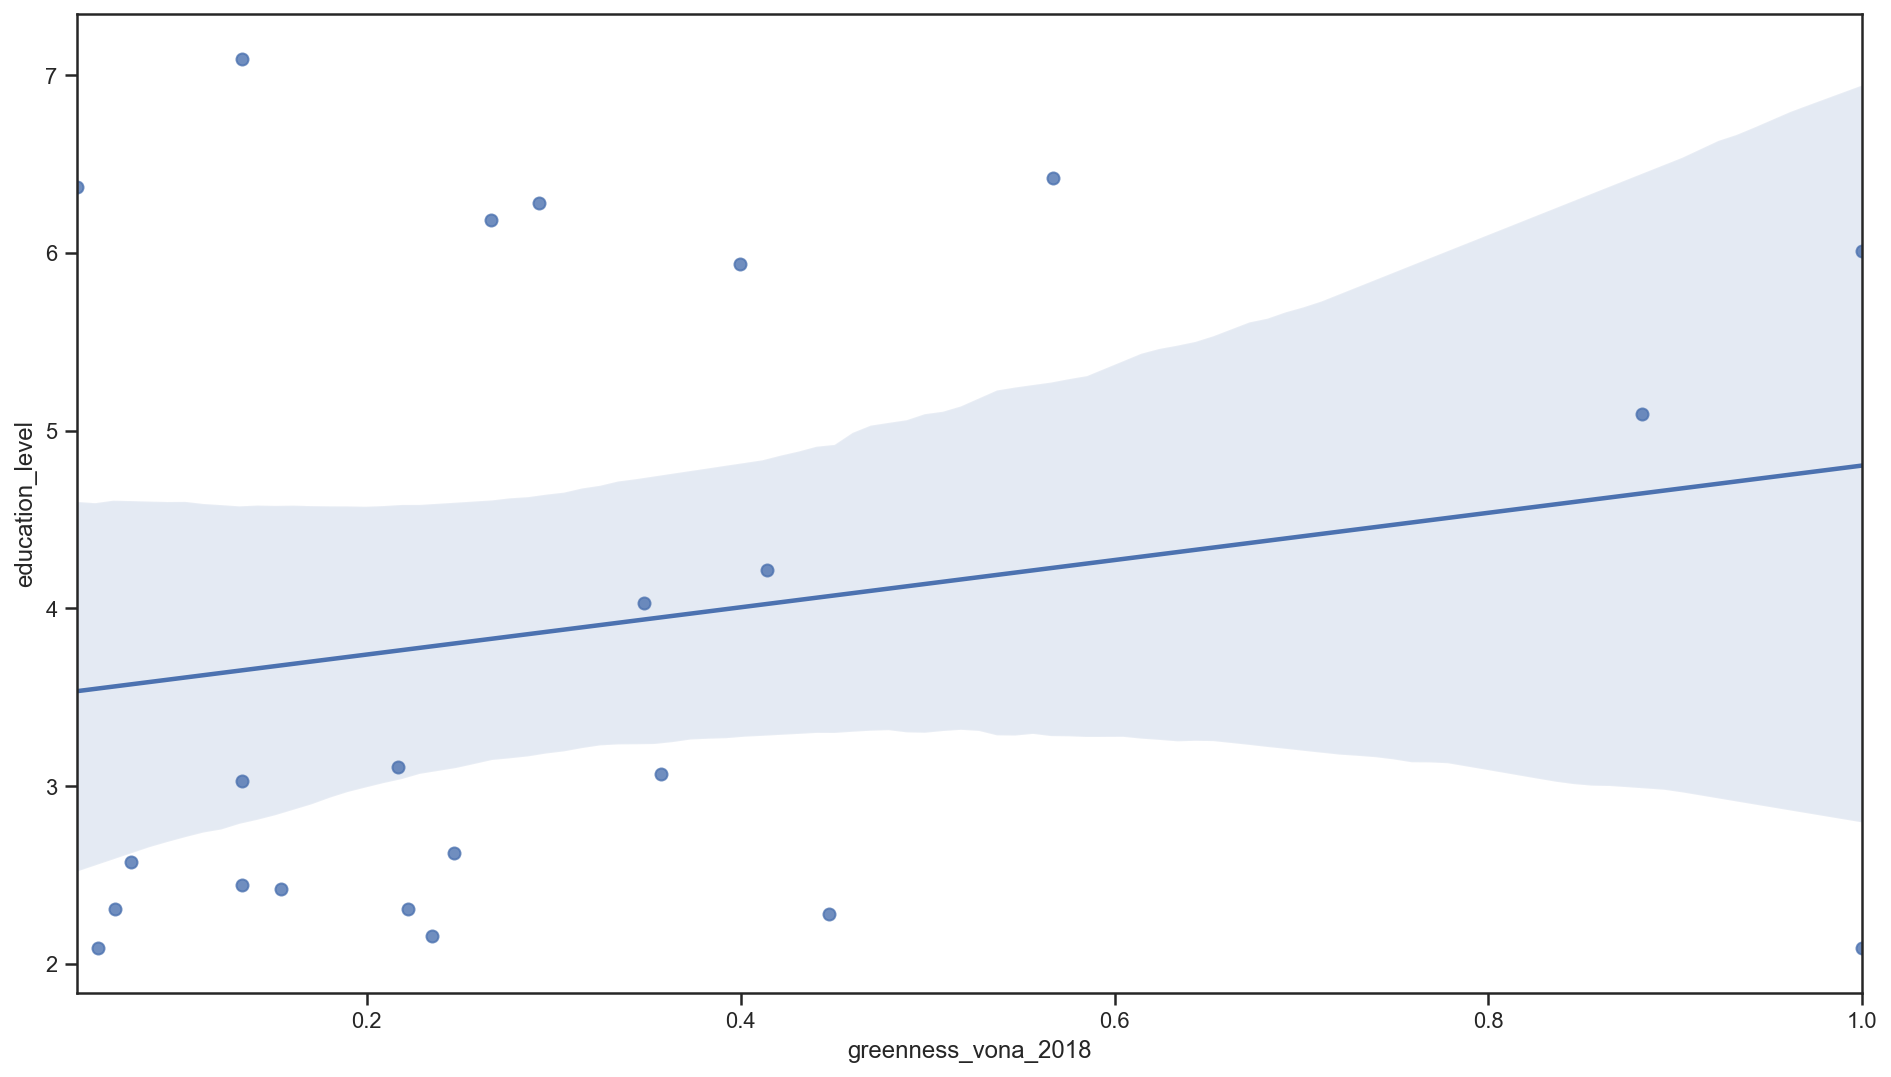

In [342]:
sns.regplot(
    x="greenness_vona_2018",
    y="education_level",
    robust=False,
    data=metadata_isco_02
)

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:title={'center':'p < 0.01'}>)

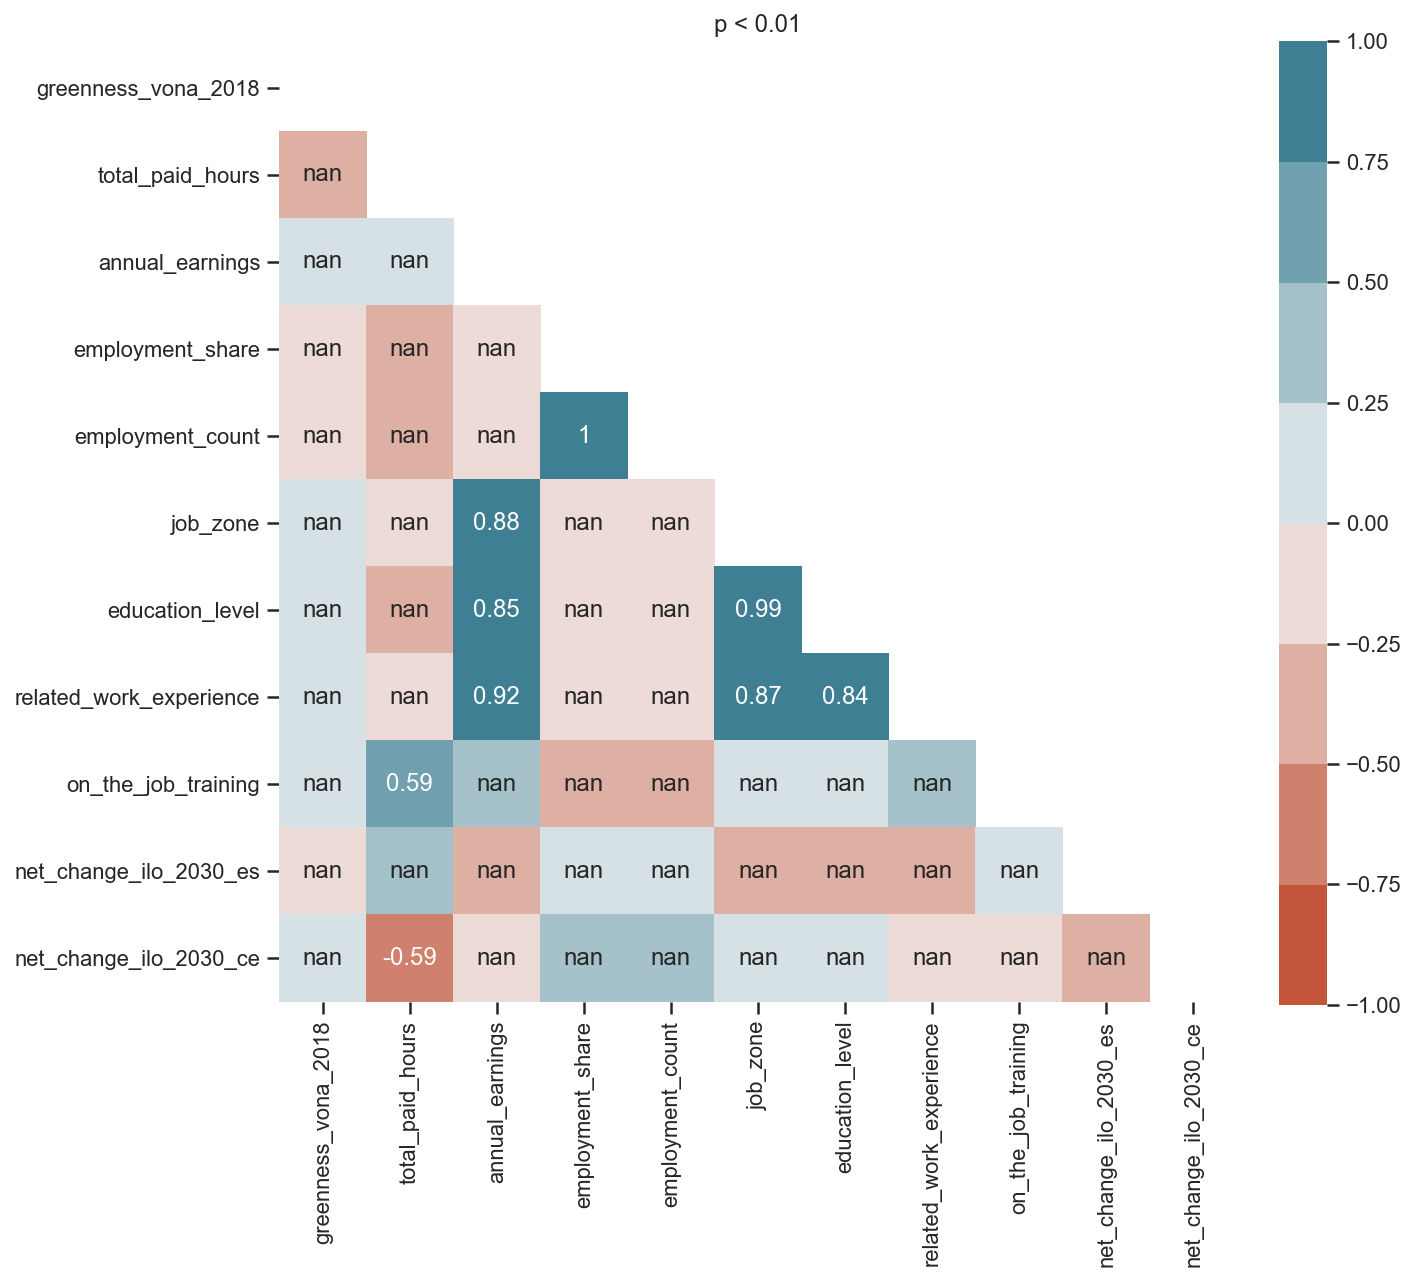

In [345]:
from src.visualization.visualize import correlation_matrix_plot

correlation_matrix_plot(metadata_isco_02, figsize=(10,10), significance_level=0.01)